<a href="https://colab.research.google.com/github/vatsalsaglani/DL-for-coders-part1-2019/blob/master/DL_LESSON_3_BIWI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !wget https://s3.amazonaws.com/fast-ai-imagelocal/biwi_head_pose.tgz

--2019-02-10 15:50:35--  https://s3.amazonaws.com/fast-ai-imagelocal/biwi_head_pose.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.16.243
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.16.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 452316199 (431M) [application/x-tar]
Saving to: ‘biwi_head_pose.tgz’

biwi_head_pose.tgz  100%[===================>] 431.36M  26.5MB/s    in 19s     

2019-02-10 15:51:00 (22.3 MB/s) - ‘biwi_head_pose.tgz’ saved [452316199/452316199]



In [0]:
# !mkdir data && tar -xvzf biwi_head_pose.tgz -C data/

<center><h1>Regression With BIWI Head and Pose dataset</h1></center>

Here at our hand we have a more advanced problem to show how to create custom datasets and do regression with images. Our task is to find the center of the head in each image. 

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *

<center><h2>Getting and converting the Data</h2></center>

In [0]:
path = Path('data/biwi_head_pose/')

In [0]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer = 6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [0]:
fname = path/'09'/'frame_00067_rgb.jpg'

In [0]:
def img2txt_name(f): return f'{str(f)[:-7]}pose.txt'


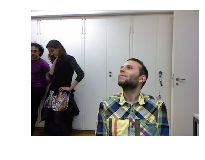

In [0]:
img = open_image(fname)
img.show()

In [0]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header = 3); ctr

array([ 86.5594,  -9.2306, 928.578 ])

get the **red** dot which indicates the _center_ of the face.

In [0]:
def convert_biwi(coords):
  c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
  c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
  return tensor([c2, c1])

def get_ctr(f):
  ctr = np.genfromtxt(img2txt_name(f), skip_header = 3)
  return convert_biwi(ctr)

def get_ip(img, pts): return ImagePoints(FlowField(img.size, pts), scale = True)

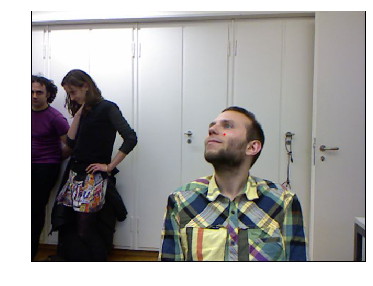

In [0]:
ctr = get_ctr(fname)
img.show(y = get_ip(img, ctr), figsize = (6,6))

In [0]:
get_ctr(fname)

tensor([235.3540, 368.2566])

Now we need a neural network which will give us the following two numbers. This isn't a classification problem, the two numbers are actual locations. 

We don't have a label or classes. This is a regression model where the ouput is a number or a some continuous output. 


**How to achieve this?**

_Same as always..._

<center><h2>Creating a dataset</h2></center>

In [0]:
# old version that doesn't work
# data = (ImageFileList.from_folder(path).label_from_func(get_cr).split_by_valid_func(lambda o: o[0].parent.name=='13').datasets(PointsDataset).transform(get_transforms(), tfm_y = True, size = (120, 60)).databunch().normalize(imagenet_stats))
# new version that works
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

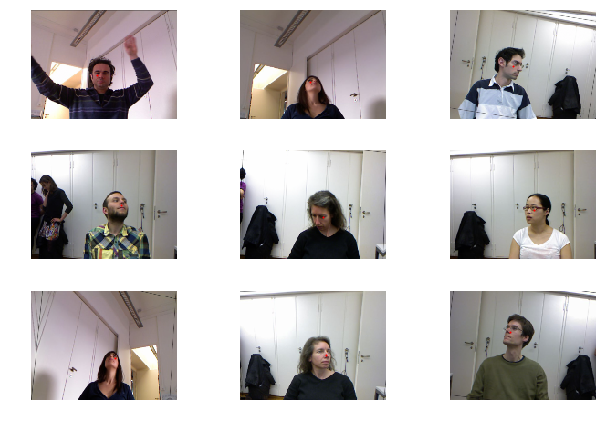

In [0]:
data.show_batch(3, figsize = (9, 6))

<center><h2>Train Model</h2></center>

In [0]:
learn = create_cnn(data, models.resnet34)
learn.loss_func = MSELossFlat()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 75216935.47it/s]


epoch,train_loss,valid_loss


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


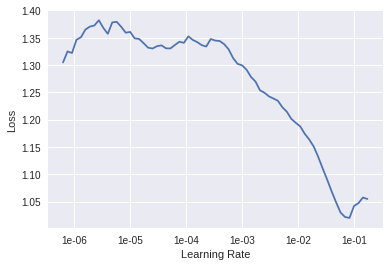

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 2e-2

In [0]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss
1,0.048735,0.004243


In [0]:
learn.save('stage-1')

In [0]:
learn.show_results()